# Lithography Aerial mask simulation with Python - Notebook

In this notebook we present some insights about the simulation of the **lithographic process**. 

Let's start with a brief reminder of lithography as seen in class. Lithography is a process used in microfabrication to pattern features onto a substrate. Typically, a photosensitive material called a photoresist is deposited onto the substrate, and a pattern is projected onto the photoresist using a mask or a set of lenses. The photoresist is then developed, removing either the exposed or unexposed areas, depending on the type of resist, and the remaining pattern is transferred to the substrate using various etching techniques.


Now, let's dive into the example for this notebook. The purpose of this code is to simulate the aerial image produced by a lithographic mask. The mask is represented by a binary image, with opaque regions represented by ones and transparent regions represented by zeros. The aerial image is a plot of the light intensity pattern that would be produced on the substrate if the mask were illuminated with coherent light. The intensity pattern is calculated using Fourier optics and can be used to predict the quality of the pattern transfer onto the substrate.

In [1]:
import numpy as np
from scipy.fftpack import fft2, ifft2, fftshift
from scipy.io import loadmat
from scipy.ndimage import measurements
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch


We will begin by setting various parameters such as the degree of accuracy, resolution, wavelength of light, numerical aperture, and threshold intensity. The mask shape is then read from a file, and its dimensions are scaled to match the smallest possible feature size of the lithographic process. The mask is centered and represented by a binary matrix.

The parameters set at the beginning of the code can be adjusted to optimize the pattern transfer onto the substrate.

In [2]:
# Parameters
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Accuracy = 8           # Degree of accuracy (integer, higher means more time more accurate)
N = 2**Accuracy + 1    # Resolution
lamda = 0.1            # Wavelength (um)
TH = 0.4               # Threshold intensity (normalized)
NA = 0.85              # Numerical aperature
L = 0.09               # Smallest possible length in the technology
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

As en example, the following coodridinates for the masks are provided as text files in the encolsing folder, you can choose one of these or upload your own.

<table><tr>
<td> <img src="../img/mask1.png" alt="Mask 1" style="width: 250px;"/> </td>
<td> <img src="../img/mask2.png" alt="Mask 2" style="width: 240px;"/> </td>
</tr></table>
<h4 align="center">Examples 1 and 2 of possible masks to use.</h4>


In [1]:
cd /home/LMIS/Litography

/home/LMIS/Litography


<h3>Selecting the mask.</h3>


Now we need to select the corresponding mask in the following block. Change the **File** definitions to the appropiate file. (Hint: in the repository you can choose between two examples for selecting a mask, or you can easily create one yourself with any CAD software, and copying the coordinates into a .txt file). 

The mask shape is read from a file and its dimensions are scaled to match the smallest possible feature size of the lithographic process. The mask is centered and represented by a binary matrix. The boundary of the mask is also plotted to visualize the mask shape.

In [11]:
# Reading mask shape from file
File = 'example1.txt'   ############ CHANGE MASK HERE
Y = np.loadtxt(File)

X = Y[:,0]
Y = Y[:,1]
num_points = len(X)-1
sides = np.zeros(num_points)
for i in range(num_points):
    sides[i] = np.sqrt((X[i]-X[i+1])**2 + (Y[i]-Y[i+1])**2)
scale = L/np.min(sides)
sides = sides*scale
X = scale*X
Y = scale*Y
X = X-np.min(X)
Y = Y-np.min(Y)
Lx = 1.4*np.max(X)    # Mask real dimensions (um)
Ly = 1.4*np.max(Y)    # Mask real dimensions (um)


We center the polygon and create a mesh matrix to align the coordinate system used for the polygon with the coordinate system used for the grid. The grid is defined by the mesh matrix, which has a regular arrangement of points in space, while the polygon is defined by its vertices in a different coordinate system. Therefore, to perform operations on the polygon in the context of the grid, we need to translate the polygon to align with the grid.

Creating the mesh matrix allows us to interpolate the polygon onto the grid, which means assigning a value to each grid point based on the polygon shape. This is necessary to perform Fourier transformations and other operations that require the input data to be in the form of a matrix.

In [6]:

# Center the polygon
x = np.linspace(-0.2*np.max(X),1.2*np.max(X),N)
y = np.linspace(-0.2*np.max(Y),1.2*np.max(Y),N)

# Create mask matrix
x,y = np.meshgrid(x,y)
x = np.reshape(x,-1)
y = np.reshape(y,-1)
mask = Path(np.column_stack((X,Y)))
mask = mask.contains_points(np.column_stack((x,y)))
mask = np.reshape(mask,(N,N))
mask = mask.astype(float)

<h3>Doing the calculations with FFT</h3>


Next, the code calculates the Fourier transform of the mask and applies the transfer function of the objective lens (i.e., the pupil function). The inverse Fourier transform of the resulting product is then taken to obtain the aerial image. The threshold intensity is applied to the aerial image to obtain a binary image, and the error between the binary mask and the binary aerial image is calculated. Finally, the boundary of the mask and the aerial image are plotted to compare the two. 

The Fourier transform of the mask is calculated, and the transfer function of the objective lens is applied. The inverse Fourier transform of the resulting product is then taken to obtain the aerial image. The threshold intensity is applied to the aerial image to obtain a binary image, and the error between the binary mask and the binary aerial image is calculated.

Creating different domains is necessary for the Fourier transform calculation. In this code, we use a discrete Fourier transform (DFT), which takes a signal or image in the spatial domain and transforms it to the frequency domain. To perform the DFT, we need to define a set of discrete frequencies in the frequency domain. These frequencies correspond to the various spatial frequencies present in the original signal or image. In the code, the discrete frequencies are created using the meshgrid function and are stored in the nx and ny arrays.

After creating the discrete frequencies, we calculate the corresponding frequency values in units of inverse micrometers (1/um) using the sampling interval dx and the size of the image N. These frequency values are stored in the fx and fy arrays. By performing the DFT with the discrete frequency domain and the spatial domain (the mask), we can obtain the Fourier transform of the mask. This transform represents the intensity distribution of the light transmitted through the mask.

In [7]:

# Calculations
# Creating different domains
dx = Lx/(N-1)
dy = Ly/(N-1)
nx, ny = np.meshgrid(np.arange(-(N-1)/2,(N-1)/2+1),np.arange(-(N-1)/2,(N-1)/2+1))
fx = (1/dx)*(1/N)*nx
fy = (1/dx)*(1/N)*ny
# Discrete frequency domain (1/um)
P = np.sqrt((fx**2)+(fy**2))
P = (P < (NA/lamda)).astype(float)
I = fftshift(fft2(mask))
I = ifft2(P*I)
I = np.real(I*np.conj(I))
I = I/np.max(I)
aerial = (I > TH).astype(float)

The transfer function of the objective lens is given by:

$$P(f_x, f_y) = \begin{cases}
1 & \text{if } \sqrt{f_x^2 + f_y^2} \leq \frac{NA}{\lambda} \\
0 & \text{otherwise}
\end{cases}$$

Where $u$ and $v$ are the spatial frequencies in the $x$ and $y$ directions, respectively, $\lambda$ is the wavelength of the light, and $NA$ is the numerical aperture of the lens. This function describes the fraction of light that is transmitted through the objective lens at each spatial frequency.

The 2D Fast Fourier Transform (FFT) equation used in this case can be expressed as:

$$ F(u,v) = \sum_{x=0}^{N-1} \sum_{y=0}^{N-1} f(x,y) e^{-i 2\pi (\frac{ux}{N}+\frac{vy}{N})} $$

where $f(x,y)$ is the input image, $F(u,v)$ is its FFT, and $N$ is the size of the image in both dimensions. The inverse FFT can be computed as:

$$ f(x,y) = \frac{1}{N^2} \sum_{u=0}^{N-1} \sum_{v=0}^{N-1} F(u,v) e^{i 2\pi (\frac{ux}{N}+\frac{vy}{N})} $$

where $F(u,v)$ is the input Fourier spectrum, and $f(x,y)$ is its inverse FFT.

<h3>Calculating the error</h3>


The error compares the boundary of the mask and the aerial image.

In [8]:

# Calculate error
mError = np.sum(np.abs(mask-aerial))
mError = 100*(mError/np.sum(mask))
print('error = ', mError, '%')

error =  26.231014208721216 %


<h3>Plotting our Aerial image and the normalized light intensity</h3>


The boundary of the mask and the aerial image are plotted to compare the two. The normalized light intensity is also plotted to visualize the intensity pattern that would be produced on the substrate.


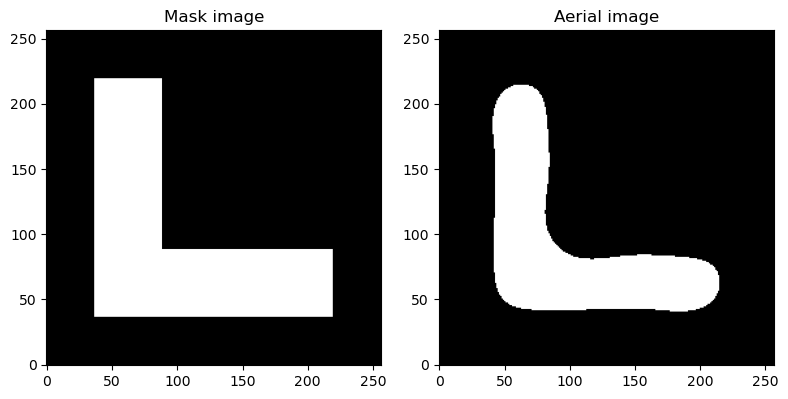

In [9]:

# Plot mask and aerial images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(mask, cmap='gray', origin='lower')
ax1.set_title('Mask image')
ax2.imshow(aerial, cmap='gray', origin='lower')
ax2.set_title('Aerial image')
plt.tight_layout()


Finally, we will plot the normalized image

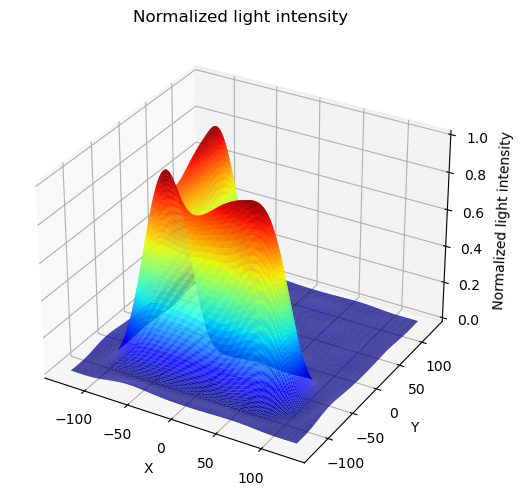

In [10]:

# Plot normalized light intensity in 3D
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(nx, ny, I, cmap='jet', rstride=1, cstride=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Normalized light intensity')
ax.set_title('Normalized light intensity')
plt.show()


Overall, we have created a useful simulation tool for predicting the quality of pattern transfer onto a substrate in a lithographic process. By adjusting the parameters and comparing the mask and aerial image, one can optimize the lithographic process to achieve high-quality pattern transfer.

*References*
- [M., & Wolf, E. (2013). Principles of optics: electromagnetic theory of propagation, interference and diffraction of light. Elsevier.](https://www.cambridge.org/core/books/principles-of-optics/D12868B8AE26B83D6D3C2193E94FFC32)
- [Goodman, J. W. (2005). Introduction to Fourier optics. Roberts and Company Publishers.](http://www.opticsjournal.net/post/ifo.pdf)